In [36]:
#-- 0. Carga de librerías
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder

In [ ]:
#-- 1. Lectura de demanda histórica
dem_df = pd.read_csv('dem_20110401_20251022.csv')
dem_df['fecha'] = pd.to_datetime(dem_df['fecha'])

#-- Se toman fechas desde el 2021, ya que tienen mayor relevancia por ser más actuales.
dem_df = dem_df.copy().loc[dem_df['anio_cal']>=2021]

In [38]:
#-- 2. Lectura de temperaturas
temp_df = pd.read_csv('temperaturas.csv')
temp_df = temp_df.copy().loc[temp_df['fecha']>='2021-01-01']
temp_df['fecha'] = pd.to_datetime(temp_df['fecha'])


In [39]:
#-- 3. Conformación de todo el dataset
#-- 3.1 Join entre temperatura y demanda
df_full = pd.merge(dem_df, temp_df, left_on=['fecha', 'rge_nemo'], right_on=['fecha', 'region'])
df_full = df_full.rename(columns={'anio_cal':'year'})

#-- 3.2 Selección de columnas
cat_cols = ['mes', 'age_nemo', 'tipo_dia']
num_cols = ['year', 'tmed']
target = ['dem_dia']
df = df_full[cat_cols + num_cols + target]

#-- 3.3 Se descartan filas con nulos (son pocos)
df = df.dropna()

#-- 3.4 Se toman los promedios mensuales
df_mensual = df.groupby(['year']+cat_cols).mean().round(2).reset_index()

#-- 3.5 Se agrega la temperatura al cuadrado
df_mensual['tmed2'] = df_mensual['tmed'] ** 2

#-- 3.6 Redefinición de columnas numéricas: se elimina year y se agrega tmed2
num_cols = ['tmed', 'tmed2']


In [40]:
#-- 4. Split
X_train, X_test, y_train, y_test = train_test_split(
    df_mensual[cat_cols + num_cols],
    df_mensual[target],
    test_size=0.3,
    random_state=42,
    stratify=df_mensual[cat_cols]
)


In [41]:
#-- 5. Codificación
#-- 5.1 Mes - codificación cíclica
X_train['mes_sin'] = np.sin(2 * np.pi * X_train['mes'] / 12)
X_train['mes_cos'] = np.cos(2 * np.pi * X_train['mes'] / 12)

#-- 5.2 age_nemo y tipo_dia - target encoding
#-- 5.2.1 Combinación de age_nemo y tipo_dia para obtener una única columna categórica
X_train['dist_tipodia'] = X_train['age_nemo'].astype(str) + '_' + X_train['tipo_dia'].astype(str)

#-- 5.2.2 Target Encoding sobre la nueva columna combinada
encoding = pd.concat([X_train, y_train], axis=1).groupby('dist_tipodia')['dem_dia'].mean()
X_train['dist_tipodia_te'] = X_train['dist_tipodia'].map(encoding)

#-- 5.2.3 Eliminar columnas originales
X_train_coded = X_train.drop(columns=['age_nemo', 'tipo_dia', 'dist_tipodia'])

In [42]:
#-- 6. Codificación del test
#-- 6.1 Mes - codificación cíclica
X_test['mes_sin'] = np.sin(2 * np.pi * X_test['mes'] / 12)
X_test['mes_cos'] = np.cos(2 * np.pi * X_test['mes'] / 12)

#-- 6.2 age_nemo y tipo_dia - target encoding
#-- 6.2.1 Combinación de age_nemo y tipo_dia para obtener una única columna categórica
X_test['dist_tipodia'] = X_test['age_nemo'].astype(str) + '_' + X_test['tipo_dia'].astype(str)

#-- 6.2.2 Coficación usando las categorías obtenidas en train
X_test['dist_tipodia_te'] = X_test['dist_tipodia'].map(encoding)

#-- 6.2.3 Manejo de categorías nuevas en test
X_test['dist_tipodia_te'].fillna(y_train['dem_dia'].mean(), inplace=True)

#-- 6.2.4 Eliminar columnas originales
X_test_coded = X_test.drop(columns=['age_nemo', 'tipo_dia', 'dist_tipodia'])

<positron-console-cell-42>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




In [43]:
#-- 7. Entrenamiento del modelo

best_model = XGBRegressor(
    booster='gbtree',
    objective='reg:squarederror',
    eval_metric='mape',
    verbosity=0
)

best_model.fit(
    X_train_coded, y_train,
    verbose=False
)

,objective,'reg:squarederror'
,base_score,None
,booster,'gbtree'
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mape'


In [44]:
#-- 8. Métricas principales
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Predicción sobre el conjunto de test
y_pred = best_model.predict(X_test_coded)

# Métricas de evaluación
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"MAE en test: {mae:.2f}")
print(f"MAPE en test: {mape:.2%}")

MAE en test: 169.41
MAPE en test: 7.29%


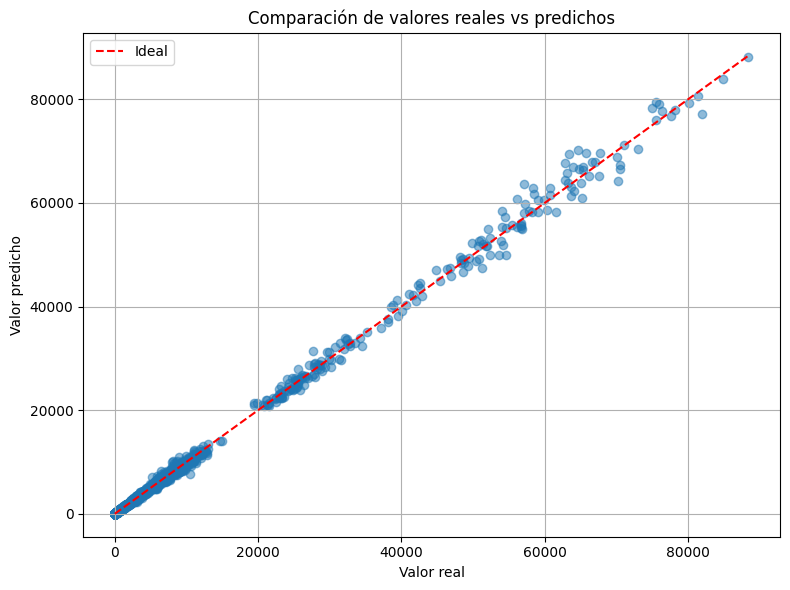

In [45]:
#-- 8. Gráfica comparativa
import matplotlib.pyplot as plt

# Asegurarse de que sean vectores 1D
y_test_1d = np.ravel(y_test)
y_pred_1d = np.ravel(y_pred)

# Crear DataFrame de comparación
df_comparacion = pd.DataFrame({
    'Real': y_test_1d,
    'Predicho': y_pred_1d
})

# Gráfico de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(df_comparacion['Real'], df_comparacion['Predicho'], alpha=0.5)
plt.plot([df_comparacion['Real'].min(), df_comparacion['Real'].max()],
         [df_comparacion['Real'].min(), df_comparacion['Real'].max()],
         color='red', linestyle='--', label='Ideal')
plt.xlabel('Valor real')
plt.ylabel('Valor predicho')
plt.title('Comparación de valores reales vs predichos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()